In [10]:
import os
import dotenv
dotenv.load_dotenv()
import scripts.update_db as udb
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
neon_db_url = os.environ.get("NEON_DB_CONSTR")
import pandas as pd
import scripts.update_db as udp

In [11]:
engine = create_engine(neon_db_url)

In [12]:
entries = pd.read_sql_table('entry', engine)

In [13]:
_positions = pd.read_excel('..\positions.xlsx', index_col=0)
_positions = _positions.loc[_positions.active == True]


In [14]:

def updated_positions(positions):
    with Session(engine) as session:
        records = [udp.PositionManager.from_row(session, row).as_dict() for i, row in positions.iterrows()]
    
    table = pd.DataFrame.from_records(records).reset_index().rename(columns={'index': 'id'})
    return table

def get_stops_triggered(positions):
    trail_triggered = ((positions.price - positions.trail) * positions.direction) < 0
    stop_triggered = ((positions.price - positions.stop) * positions.direction) < 0
    regime_triggered = positions.regime != positions.direction
    return positions.loc[trail_triggered | stop_triggered | regime_triggered].copy()


def get_target_triggered(positions):
    target_triggered = ((positions.price - positions.target) * positions.direction) >= 0
    return positions.loc[target_triggered].copy()


def plot_current_position_data(positions):
    for i, row in positions.iterrows():
        _price = pd.read_sql(f'select * from stock_data where stock_data.stock_id = {row.stock_id}', engine)
        _price['cost'] = row.cost
        _price['stop'] = row.stop 
        _price['target'] = row.target 
        _price['trail'] = row.trail 
        _price['m_close'] = _price['close']
        _price[['m_close', 'target', 'trail', 'cost', 'stop']].iloc[-100:].plot(
            color=['black', 'green', 'orange', 'blue', 'red'],
            title=row.symbol
        )
            

In [15]:
current_position_data = updated_positions(_positions)

In [16]:
stops_triggered = get_stops_triggered(current_position_data)
stops_triggered

,id,entry_date,symbol,is_relative,cost,stop,trail,price,trail_amount,target,quantity,direction,risk,multiple,fraction,stock_id,regime
2,2,2023-12-07,XLRE,True,82.649,84.076,82.736119,85.974769,1.3753,81.935,-700,-1,1000,1,0.666667,34,-1.0
3,3,2023-12-07,XLB,True,178.418,183.136,179.813849,180.854447,2.7610,176.059,-150,-1,1000,1,0.666667,32,-1.0
4,4,2023-12-07,XLI,True,237.338,242.480,238.637080,239.944874,1.6150,234.767,-150,-1,1000,1,0.666667,27,-1.0
5,5,2023-12-07,XLK,True,403.794,388.590,406.551302,404.410050,2.2540,411.394,60,1,1000,1,0.666667,28,1.0


In [17]:
_target_triggered = get_target_triggered(current_position_data)
_target_triggered

,id,entry_date,symbol,is_relative,cost,stop,trail,price,trail_amount,target,quantity,direction,risk,multiple,fraction,stock_id,regime
0,0,2023-12-04,XLY,True,373.370557,363.052664,374.968711,379.518711,4.55,378.529503,100,1,1000,1,0.666667,30,1.0


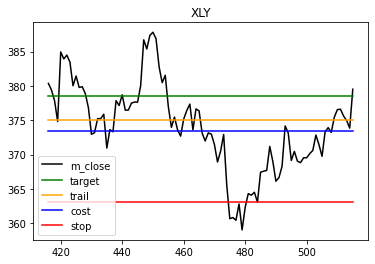

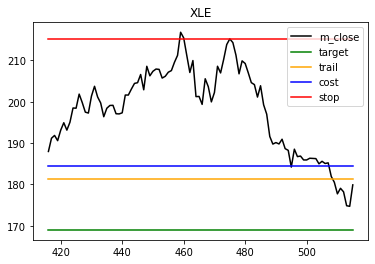

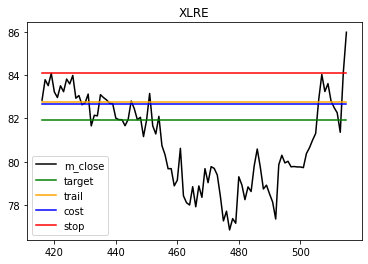

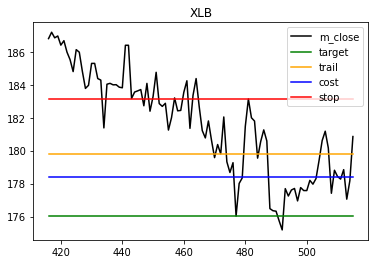

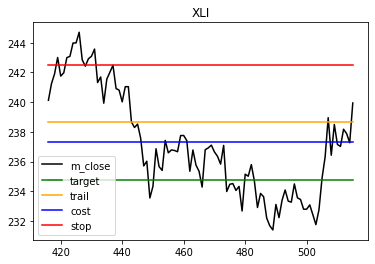

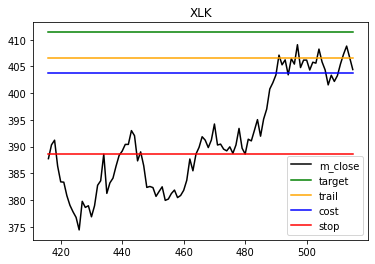

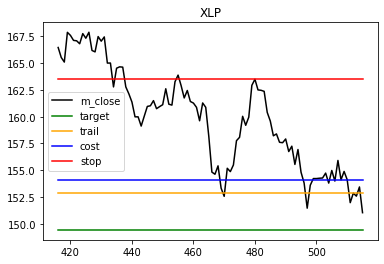

In [18]:
plot_current_position_data(current_position_data)